# TEST CODE

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

"""
%matplotlib inline 이란, Jupyter Notebook에서 사용하는 매직 명령어로, 
그래프나 플롯을 코드 셀 아래에 직접 표시하도록 한다. 
그래프가 별도의 팝업창을 띄우지 않고 코드 셀 아래에 바로 출력셀로 나타난다.
"""
%matplotlib inline 

In [20]:
# h5 구조를 확인하는 방법
"""
[구조]
    Dataset (여러개)
        - name
        - shape
        - data type(dtype)
    Group
        - group name
        - sub name (여러개)
            - name
            - shape
            - data type(dtype)

    *요약* Dataset을 여러개 모은것을 Group으로 하고, Dataset은 단일구성이다.
"""
def checkH5design(file_path):
    print(f"\n## analysis file of [{file_path}] ##")
    with h5py.File(file_path, 'r') as h5_file:
        for name in h5_file:
            dataset = h5_file[name]
            if isinstance(dataset, h5py.Dataset):
                print(f"Dataset: {name}")
                print(" - Shape:", dataset.shape)
                print(" - Data type:", dataset.dtype)
            elif isinstance(dataset, h5py.Group):
                print(f"Group: {name}")
                print(" - Sub-items:")
                for sub_name in dataset:
                    sub_dataset = dataset[sub_name]
                    print(f"   - {sub_name} (Shape: {sub_dataset.shape}, Type: {sub_dataset.dtype})")

trainDataSet = 'datasets/train_catvnoncat.h5'
testDataSet = 'datasets/test_catvnoncat.h5'
checkH5design(trainDataSet)
checkH5design(testDataSet)


## analysis file of [datasets/train_catvnoncat.h5] ##
Dataset: list_classes
 - Shape: (2,)
 - Data type: |S7
Dataset: train_set_x
 - Shape: (209, 64, 64, 3)
 - Data type: uint8
Dataset: train_set_y
 - Shape: (209,)
 - Data type: int64

## analysis file of [datasets/test_catvnoncat.h5] ##
Dataset: list_classes
 - Shape: (2,)
 - Data type: |S7
Dataset: test_set_x
 - Shape: (50, 64, 64, 3)
 - Data type: uint8
Dataset: test_set_y
 - Shape: (50,)
 - Data type: int64


In [29]:
def load_dataset():
    """
    # h5 확장자 파일이란?
      - h5 파일은 계층구조로 포함된 파일 시스템과 비슷한 형태를 가지고 있다.
        바이너리 포멧으로 데이터를 저장하기 때문에 이미지나 숫자 데이터 처럼 크고 복잡한 데이터 구조를 담을 수 있다.
    """
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    #print(train_set_y_orig.shape)

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    """
    # h5 파일에 list_classes 데이터 셋을 넣은 이유?
      - *[코드 가독성 향상]* *클래스 레이블을 더 명확하고 직관적*으로 이해할 수 있도록 하기 위함이다.
        예를 들어 train_set_y 0과 1은 인간이 이해하기 어려운 내용이므로, list_classes 라는 클래스 레이블을만들어서 
        직관적으로 이해할 수 있도록 한다.
      - *[데이터셋 재사용성]* 데이터셋에 새로운 클래스가 추가되거나, 클래스 레이블이 여러 개로 확장될 경우 0,1 과 같은
        숫자형 레이블 대신, 문자열 기반의 클래스명을 직접 사용하여 코드의 수정 없이 의미를 명확하게 전달할 수 있다.
    """
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    """ 
    # reshape 하는 이유 ? 
      - 코드를 편리하게 사용하기 위함이다. 
      - 예를 들어 (209, ) shape의 array의 경우 1차원 배열이지만, (1, 209) 의 경우 2차원 배열이라 재사용성이나 가독성에 뛰어나다.
    """
    
    #print("<reshape>")
    #print(train_set_y_orig.shape)
    #print(train_set_y_orig)
    #print(train_set_y_orig[0])
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [15]:
# Loading the data (cat/ non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
"""
    <train data set>
    train_set_x_orig = example datas
    train_set_y = example labeling data

    <test data set>
    test_set_x_orig = test image data
    test_set_y = test labeling data
"""

"""
    첫 번째 차원 (1): 이미지 개수를 나타내며, 이 경우 1개의 이미지만 포함하고 있습니다.
    두 번째 차원 (64): 이미지의 **세로(높이)**에 해당하며, 픽셀 위치를 나타냅니다.
    세 번째 차원 (64): 이미지의 **가로(너비)**에 해당하며, 역시 픽셀 위치를 나타냅니다.
    네 번째 차원 (3): 각 픽셀의 색상 정보를 나타내는 RGB 채널 값입니다.
"""
# do print
print(train_set_x_orig.shape) #(209, 64, 64, 3) # 209 개의 64 by 64 로 정형화된 이미지가 저장되어 있으며, 3은 RGB를 나타낸다.
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)
[b'non-cat' b'cat']
[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]


In [38]:
# 랜덤 숫자 배열 하나를 만들어보기
example_data = np.random.rand(1,64,64,3)
"""
    - (1,64,64,3) 은 (image 순서, Y, X, RGB 이다.) ## X = 가로, Y = 세로
    - 예를 들어 print(example_data[0, 0, 10]) 의 경우 X = 10, Y = 0 을 나타낸다

"""
print(example_data.shape) # (1,64,64,3)
print(example_data[0,0,10]) # X = 10, Y = 0 위치의 값을 출력하는 코드 이다.

(1, 64, 64, 3)
[0.91510485 0.98304388 0.35784704]


[72 62 22]
[ 62 128   8]


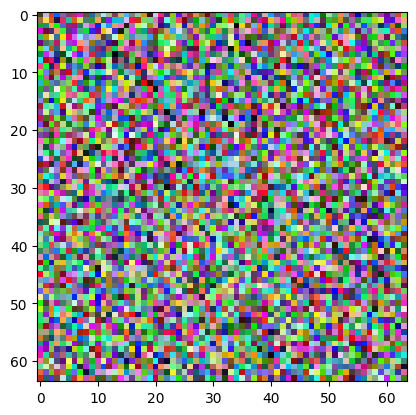

In [45]:
# 랜덤 이미지 파일을 만들어보기
# unsigned 8-bit integer, '유니트팔' 으로 선언하는 이유는 RGB 값이 255개의 값을 가지기 때문이다.

#random image
# 0 ~ 255 까지의 숫자를 랜덤으로 (64, 64, 3) shape의 배열에 넣어라. 
# 64 = X, Y 위치정보 이고 3은 RGB 값이다.
rd_picture_example_data = np.random.randint(0, 255, (64,64,3), dtype=np.uint8 ) #random color image create

#black image
bl_image = np.zeros((64, 64, 3), dtype=np.uint8) #8바이트의 정수까지가 RGB의 한계이기 때문에 uint8으로 한다. 

#white image
wh_image = np.full((64, 64, 3), 255, dtype = np.uint8) # white image create

"""
    - 3차원 배열이기 때문에 이미지 index를 넣을 필요 없이 Y, X 좌표를 가지고 RGB를 출력할 수 있다. 
    - 왼쪽 상단(0,0) 부터 우측 하단까지 (63,63) 까지의 범위로 생성되어 있다. 
"""
print(rd_picture_example_data[0,0])  # 좌측 최상단
print(rd_picture_example_data[63,63]) # 우측 최하단
plt.imshow(rd_picture_example_data)

#plt.imshow(bl_image)
#plt.imshow(wh_image)